In [6]:
import pandas as pd
import numpy as np
from gensim.parsing.preprocessing import preprocess_string, remove_stopwords, strip_numeric, strip_punctuation, strip_short, stem_text
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocess 10-K filings

In [7]:
# Load CSV
data_by_year = {}
relevant_cols = ["cik", "ticker", "filing_date", "item1a_risk", "item7_mda"]
path = "../Files/"
for year in range(2009,2021):
    data_by_year[year] = pd.read_csv(path + str(year) + ".csv", usecols=relevant_cols)
    data_by_year[year] = data_by_year[year].dropna(subset=['cik', 'item1a_risk', 'item7_mda']).drop_duplicates()
    data_by_year[year]["filing_date"] = pd.to_datetime(data_by_year[year]["filing_date"])
    data_by_year[year]["year"] = year
    data_by_year[year]["filing_year"] =  pd.DatetimeIndex(data_by_year[year]["filing_date"]).year

In [8]:
# Dirty logic for collapsing groups. Reformat as needed - currently pretty dumb
def collapse_cik_groups(grp):
    if len(grp) > 1:
        """ If the 1a and 7 text is the same, take the most recent (regardless of ticker)"""
        if (grp.iloc[0,3] == grp["item1a_risk"]).all() and (grp.iloc[0,3] == grp["item7_mda"]).all():
            # Seems like its sorted by filing_date originally - just take the last
            return grp.iloc[-1,:]
        else:
            """For now, just return the most recent"""
            return grp.iloc[-1,:]
    else:
        return grp.squeeze()

pre_grouping_sizes = []
post_grouping_sizes = []

for year in range(2009,2021):
    pre_grouping_sizes.append(len(data_by_year[year]))
    data_by_year[year] = data_by_year[year].groupby("cik").apply(lambda grp: collapse_cik_groups(grp)).reset_index(drop=True)
    post_grouping_sizes.append(len(data_by_year[year])) 

In [9]:
# Output some metrics on data-loss
for pre_size, post_size, year in zip(pre_grouping_sizes, post_grouping_sizes, list(range(2009,2021))):
    num_lost = pre_size - post_size
    percent_lost = float(num_lost) / float(pre_size)
    display("{:n} lost {:.0%}, {} rows total".format(year, percent_lost, num_lost))

num_lost = sum(pre_grouping_sizes) - sum(post_grouping_sizes)
percent_lost = float(num_lost) / float(sum(pre_grouping_sizes))
display("In total lost {:.0%}, {} rows total".format(percent_lost, num_lost))

'2009 lost 2%, 14 rows total'

'2010 lost 2%, 51 rows total'

'2011 lost 2%, 58 rows total'

'2012 lost 2%, 56 rows total'

'2013 lost 2%, 60 rows total'

'2014 lost 2%, 68 rows total'

'2015 lost 2%, 76 rows total'

'2016 lost 2%, 73 rows total'

'2017 lost 2%, 83 rows total'

'2018 lost 2%, 86 rows total'

'2019 lost 3%, 87 rows total'

'2020 lost 3%, 62 rows total'

'In total lost 2%, 774 rows total'

In [10]:
# Concat all dataframes into a single one
text_dfs = pd.concat(data_by_year.values(), ignore_index=True)
text_dfs

,cik,ticker,filing_date,item1a_risk,item7_mda,year,filing_year
0,1750,AIR,2009-07-16,> ITEM 1A. RISK FACTORS The following is a des...,> ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS...,2009,2009
1,2034,ACET,2009-09-11,>Item 1A. Risk factors You should carefully co...,>Item 7. Management s Discussion and Analysis ...,2009,2009
2,2491,BYI,2009-08-20,> ITEM 1A. RISK FACTORS Our business and inves...,> ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS...,2009,2009
3,2969,APD,2009-11-25,>ITEM 1A. RISK FACTORS The Company operates in...,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2009,2009
4,3545,ALCO,2009-12-14,>Item 1A. Risk Factors. Alico s operations inv...,>Item 7. Management s Discussion and Analysis ...,2009,2009
...,...,...,...,...,...,...,...
36346,1796129,LSACU,2020-09-23,>ITEM 1A. RISK FACTORS 13,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2020,2020
36347,1796587,NO_TICKER,2020-05-21,>Item 1A.Risk Factors.Item 2.Properties.,>Item 7.Management's Discussion and Analysis o...,2020,2020
36348,1797956,CPOW,2020-08-11,>Item 1A. Risk Factors. We discuss our expecta...,>Item 7. Management s Discussion and Analysis ...,2020,2020
36349,1799186,NONE,2020-06-25,">Item 1A, Risk Factors (c) Item 2, Properties ...",">Item 7, Management s Discussion and Analysis ...",2020,2020


# Load target data

In [11]:
# Load predictions

relevant_cols = ["PERMID", "CIK", "Ticker", "year", "FilingDate", "company_name", "Dividend Payer", "DPS growth", "DPS cut", "zEnvironmental", "dEnvironmental", "sector"]
predictions = pd.read_excel(path + "predictions.xlsx", sheet_name="data", skiprows=32, usecols=relevant_cols)
predictions.columns = ["perm_id", "cik", "ticker", "year", "filing_date", "company_name", "is_dividend_payer", "dps_change", "is_dps_cut", "z_environmental", "d_environmental", "sector"]
predictions['perm_id'] = predictions['perm_id'].str.replace(r"[^0-9]",'')
predictions["filing_date"] = pd.to_datetime(predictions["filing_date"])
predictions["filing_year"] = pd.DatetimeIndex(predictions["filing_date"]).year

""" Difference in filing_date and the year (ticker AA  has 2016 w/ 2017 filing)"""
predictions

,perm_id,cik,ticker,year,filing_date,company_name,is_dividend_payer,dps_change,is_dps_cut,z_environmental,d_environmental,sector,filing_year
0,229,1090872,A,2012,2012-12-20,AGILENT TECHNOLOGIES INC,1.0,0.421053,0.0,2.449925,-1.408006,Health Care,2012
1,229,1090872,A,2013,2013-12-19,AGILENT TECHNOLOGIES INC,1.0,0.137652,0.0,1.666993,1.117957,Health Care,2013
2,229,1090872,A,2014,2014-12-22,AGILENT TECHNOLOGIES INC,1.0,-0.275862,1.0,2.154238,-0.193752,Health Care,2014
3,229,1090872,A,2015,2015-12-21,AGILENT TECHNOLOGIES INC,1.0,0.139535,0.0,2.069083,0.039619,Health Care,2015
4,229,1090872,A,2016,2016-12-20,AGILENT TECHNOLOGIES INC,1.0,0.137652,0.0,2.087030,-0.112717,Health Care,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27030,3286,1011006,YHOO,2015,2016-02-29,ALTABA INC,0.0,NaN,NaN,-0.180481,-1.653875,Consumer,2016
27031,3286,1011006,YHOO,2016,2017-03-01,ALTABA INC,0.0,NaN,NaN,-0.836055,NaN,Consumer,2017
27032,2000,887568,ZOLL,2010,2010-12-17,ZOLL MEDICAL CORP,0.0,NaN,NaN,NaN,NaN,Health Care,2010
27033,2000,887568,ZOLL,2011,2011-11-23,ZOLL MEDICAL CORP,0.0,NaN,NaN,NaN,NaN,Health Care,2011


# Explore data pre-merge

Lets find all of the CIKs that show up in both datasets and try to figure out if the issue is the data itself or the way it is being processed.

Note: Text == 10-K filings, Metrics = Predictions given

Key Takeaways:
- 10% of the unique CIKs found in 10-k filings cannot be found in the metrics (this doesn't neccesarily mean that 10% of the rows cannot be joined, since there could just be a single year of data for a single CIK). This is unlikely to be due to pre-processing because we group by CIK and only remove rows that are duplicates
- 

In [43]:
pred_ciks = set(predictions.cik.unique())
text_ciks = set(text_dfs.cik.unique())

intersection = pred_ciks.intersection(text_ciks)
union = pred_ciks.union(text_ciks)
text_only = text_ciks.difference(pred_ciks)
pred_only = pred_ciks.difference(text_ciks)
common_ciks = sorted(list(intersection))

display("Total of {:n} unique CIKs".format(len(union)))
display("# and % of CIKs in intersection: ({:n},{:.0%})".format(len(intersection), float(len(intersection)) / float(len(union)))) 
display("# and % of CIKs only found in 10-K: ({:n},{:.0%})".format(len(text_only), float(len(text_only)) / float(len(union))))
display("# and % of CIKs only found in metrics: ({:n},{:.0%})".format(len(pred_only), float(len(pred_only)) / float(len(union))))

'Total of 5262 unique CIKs'

'# and % of CIKs in intersection: (4645,88%)'

'# and % of CIKs only found in 10-K: (595,11%)'

'# and % of CIKs only found in metrics: (22,0%)'

In [51]:
"""
    For both the 10-K text and metrics for prediction, lets create a 2D binary array where the value
    is 1 if there is a datum for that (cik,year) and 0 otherwise. This 2D array has CIKs by row and year by column.
    Return these binary arrays as well as their logical and (meaning data exists for both) as well as having the
    same value (Not a mismatch)
"""
def find_valid(year_start, year_end, text_col, metrics_col):
    num_years = year_end - year_start + 1
    valid_text = []
    valid_metrics = []
    
    textDF = text_dfs[(text_dfs.loc[:,text_col] >= year_start) & (text_dfs.loc[:,text_col] <= year_end)]
    metricsDF = predictions[(predictions.loc[:,metrics_col] >= year_start) & (predictions.loc[:,metrics_col] <= year_end) ]
    
    for cik in common_ciks: #Sorted list of CIKs
        text_binary = [0] * num_years
        for year in textDF[textDF.cik == cik].loc[:,text_col]:
            text_binary[year_start - year] = 1
        valid_text.append(text_binary)
        
        metric_binary = [0] * num_years
        for year in metricsDF[metricsDF.cik == cik].loc[:,metrics_col]:
            metric_binary[year_start - year] = 1
        valid_metrics.append(metric_binary)
        
    valid_text = np.array(valid_text)
    valid_metrics = np.array(valid_metrics)
    binary_both = np.logical_and(valid_text, valid_metrics)
    binary_same = valid_text == valid_metrics
    
    total_datapoints = float(num_years * len(common_ciks))
    display("# and % of present entries in text: ({:n},{:.0%})".format(valid_text.sum(), float(valid_text.sum()) / total_datapoints)) 
    display("# and % of present entries in metrics: ({:n},{:.0%})".format(valid_metrics.sum(), float(valid_metrics.sum()) / total_datapoints)) 
    display("# and % of present entries in text & metrics: ({:n},{:.0%})".format(binary_both.sum(), float(binary_both.sum()) / total_datapoints))
    display("# and % of entries in text & metrics that have the same value: ({:n},{:.0%})".format(binary_same.sum(), float(binary_same.sum()) / total_datapoints))

    return (valid_text, valid_metrics, binary_both, valid_text == valid_metrics)

Try this viz w/o the first 3 years of data (2009, 2010, 2011) + using filing_year for metrics instead

## On columns=Year, 2009-2020

In [52]:
sns.set(rc={'figure.figsize':(10,15)})
binary_text, binary_metrics, binary_both, binary_same = find_valid(2009,2020, "year", "year")

'# and % of present entries in text: (34275,67%)'

'# and % of present entries in metrics: (26929,53%)'

'# and % of present entries in text & metrics: (25504,50%)'

'# and % of entries in text & metrics that have the same value: (40899,80%)'

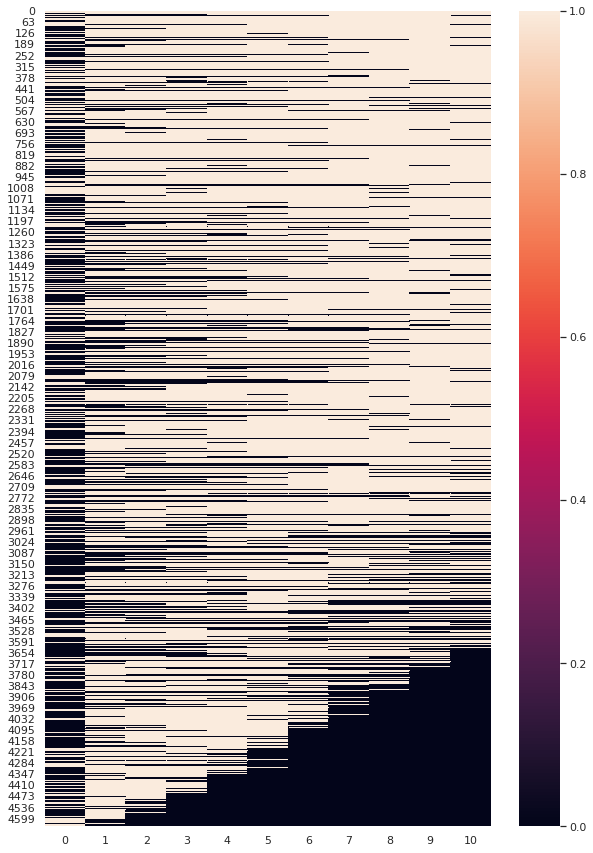

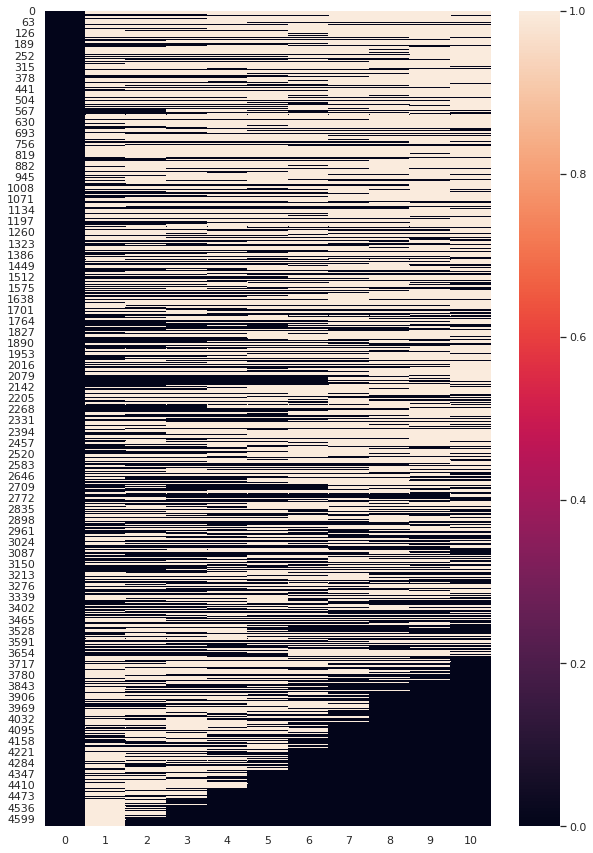

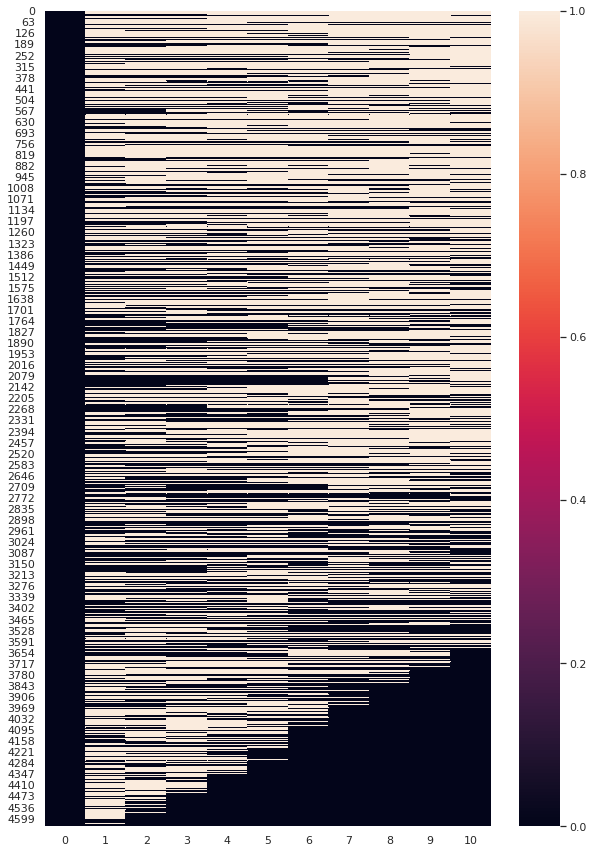

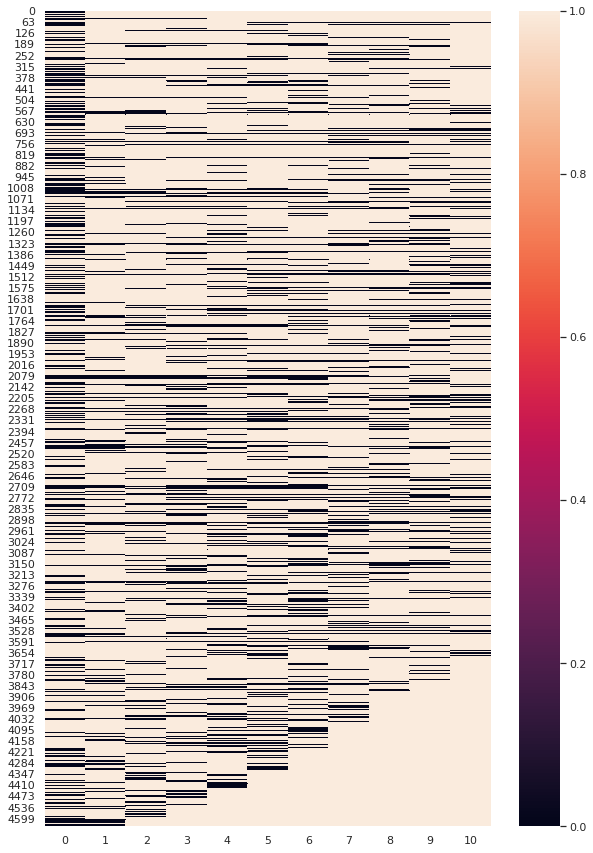

In [56]:
plt.figure()
sns.heatmap(binary_text)
plt.savefig("Vanilla_Text_Heatmap.jpg")

plt.figure()
sns.heatmap(binary_metrics)
plt.savefig("Vanilla_Metric_Heatmap.jpg")

plt.figure()
sns.heatmap(binary_both)
plt.savefig("Vanilla_Both_Heatmap.jpg")

plt.figure()
sns.heatmap(binary_same)
plt.savefig("Vanilla_BothEqual_Heatmap.jpg")

## On columns=Year, 2012-2020 (Excluding 2009, 2010, 2011 as we were interested in using just the 10-K text for the LDA corpus for this era, w/o prediction)

In [57]:
binary_text, binary_metrics, binary_both, binary_same = find_valid(2012,2020, "year", "year")

'# and % of present entries in text: (26835,72%)'

'# and % of present entries in metrics: (21732,58%)'

'# and % of present entries in text & metrics: (20662,56%)'

'# and % of entries in text & metrics that have the same value: (29917,81%)'

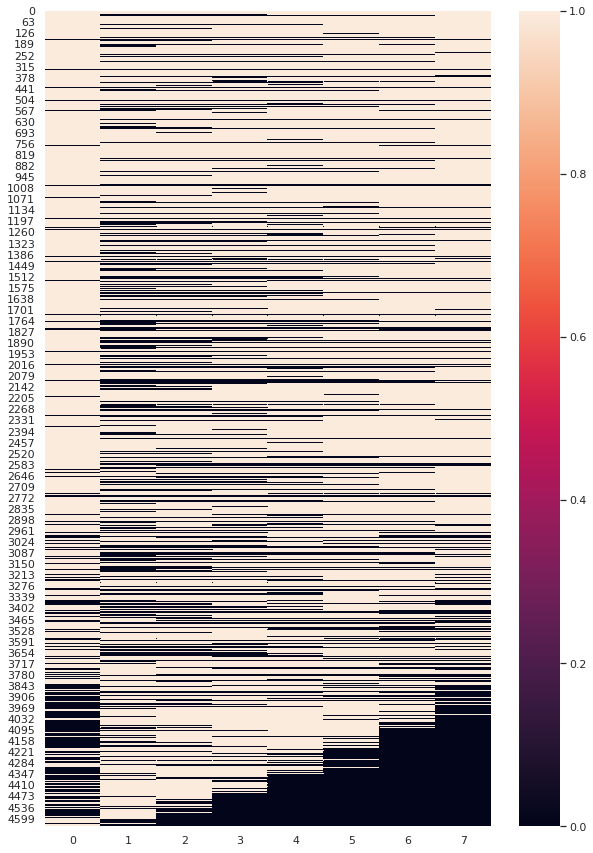

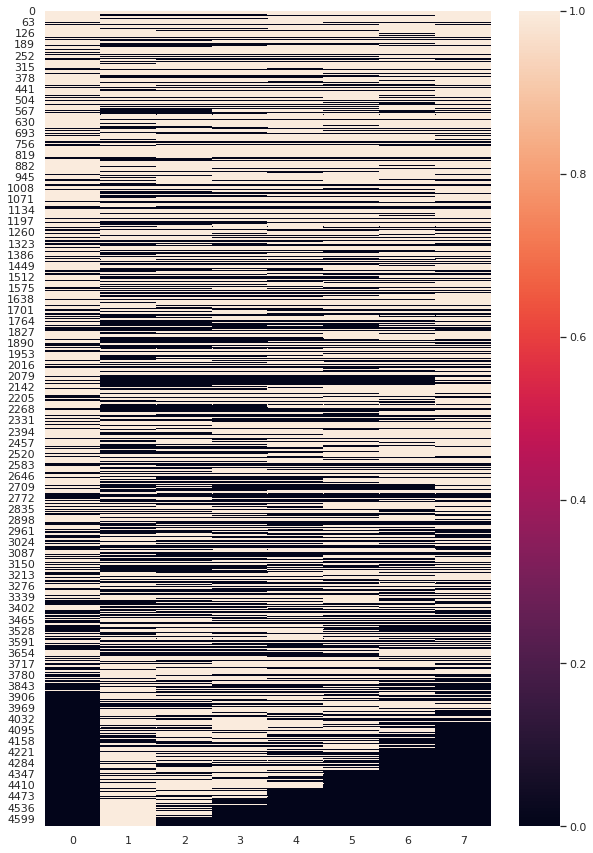

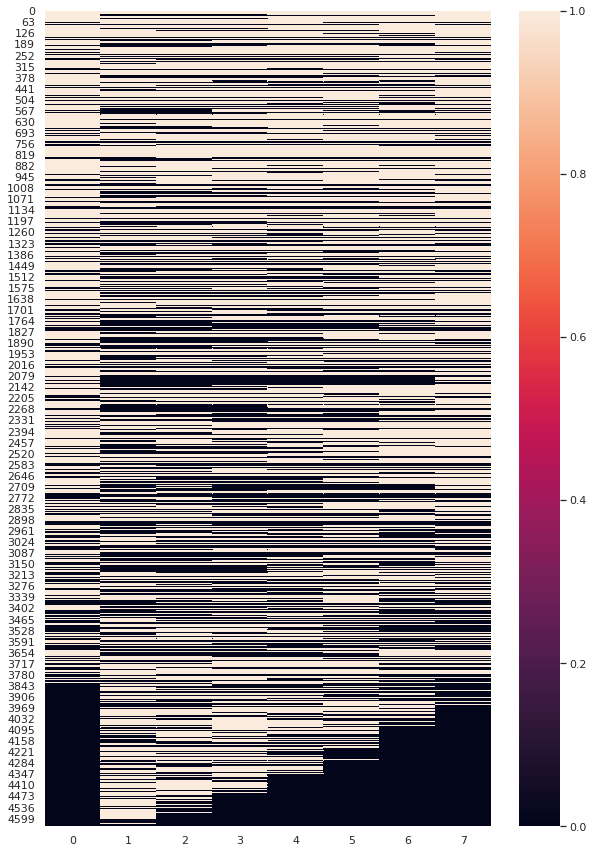

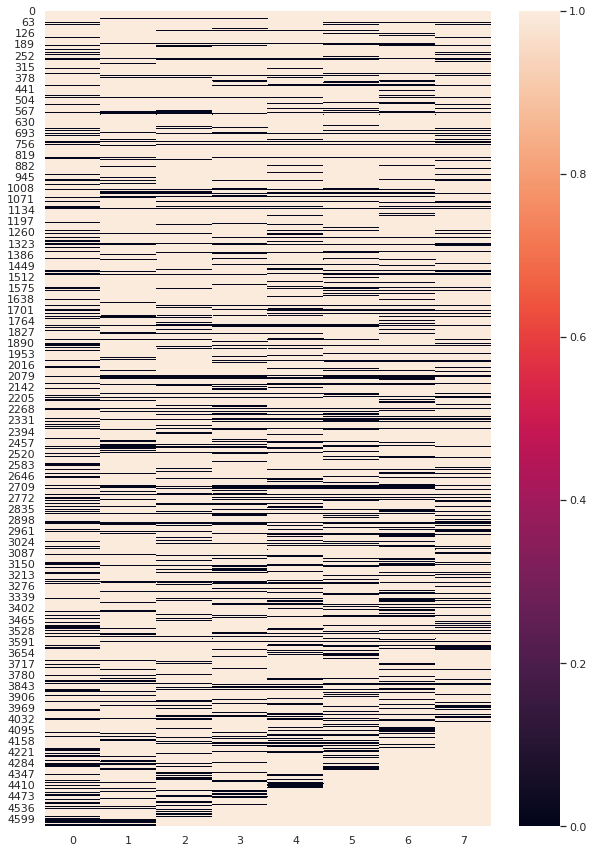

In [58]:
plt.figure()
sns.heatmap(binary_text)
plt.savefig("Without3_Text_Heatmap.jpg")

plt.figure()
sns.heatmap(binary_metrics)
plt.savefig("Without3_Metric_Heatmap.jpg")

plt.figure()
sns.heatmap(binary_both)
plt.savefig("Without3_Both_Heatmap.jpg")

plt.figure()
sns.heatmap(binary_same)
plt.savefig("Without3_BothEqual_Heatmap.jpg")

## On columns=Year for 10-K text, filing_year for metrics, 2009-2020

In [63]:
binary_text, binary_metrics, binary_both, binary_same = find_valid(2009,2020, "year", "filing_year")

'# and % of present entries in text: (34275,67%)'

'# and % of present entries in metrics: (26904,53%)'

'# and % of present entries in text & metrics: (25069,49%)'

'# and % of entries in text & metrics that have the same value: (40054,78%)'

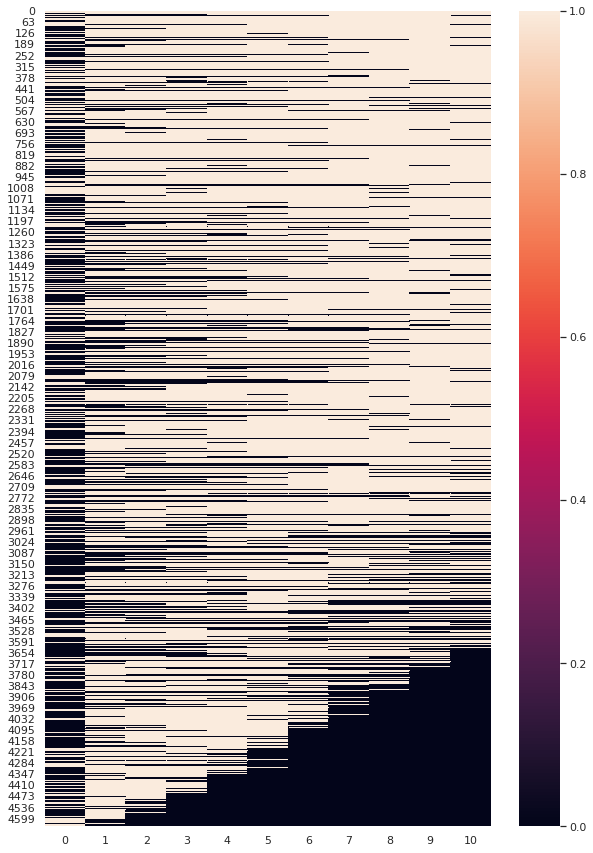

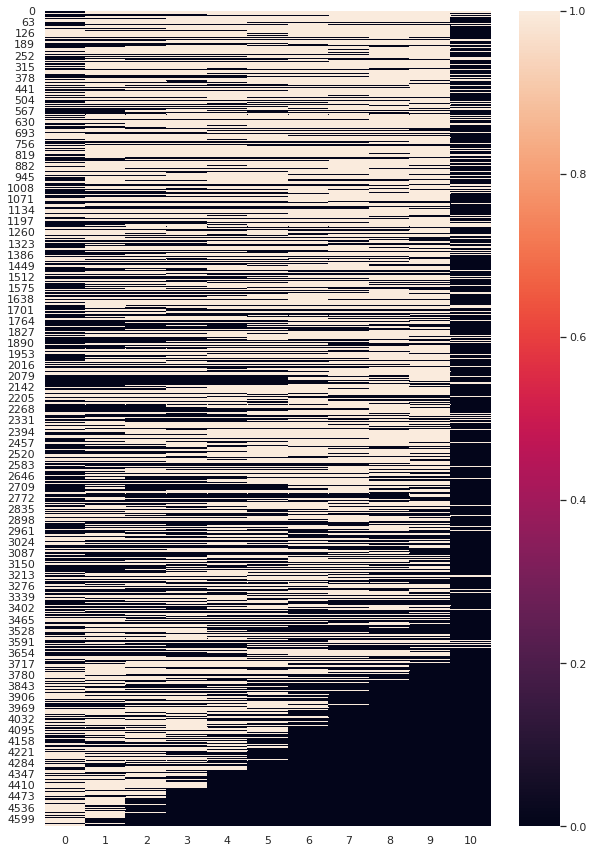

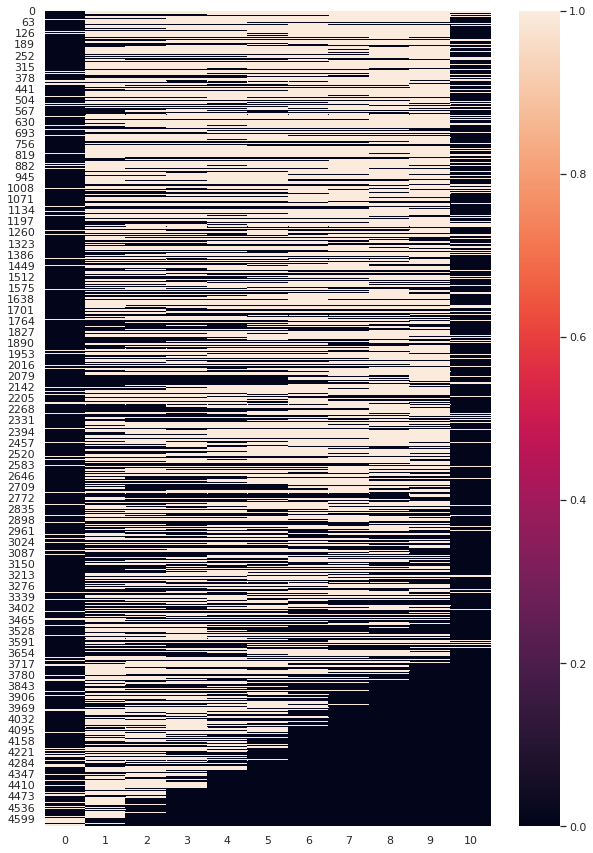

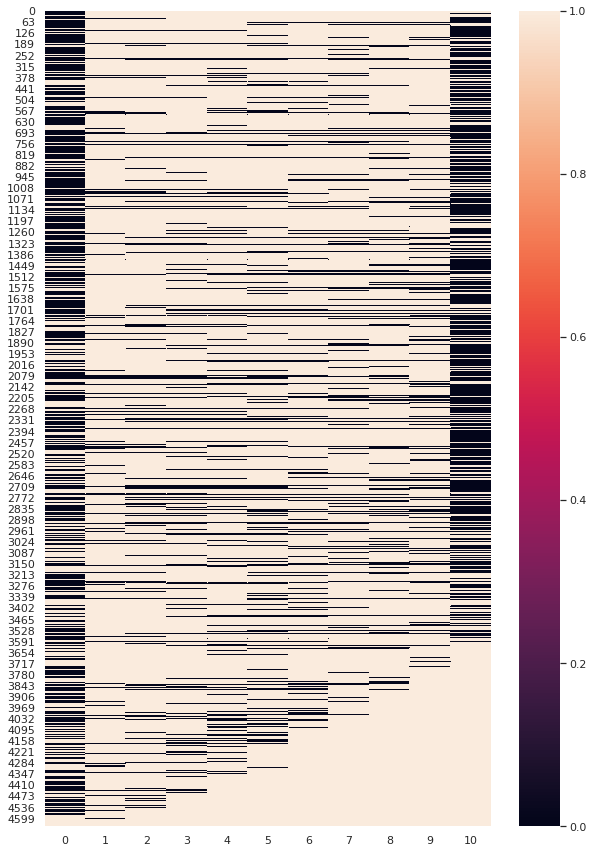

In [64]:
plt.figure()
sns.heatmap(binary_text)
plt.savefig("MetricFilingYear_Text_Heatmap.jpg")

plt.figure()
sns.heatmap(binary_metrics)
plt.savefig("MetricFilingYear_Metric_Heatmap.jpg")

plt.figure()
sns.heatmap(binary_both)
plt.savefig("MetricFilingYear_Both_Heatmap.jpg")

plt.figure()
sns.heatmap(binary_same)
plt.savefig("MetricFilingYear_BothEqual_Heatmap.jpg")

## On columns=Year for 10-K text, filing_year for metrics, 2012-2020

In [65]:
binary_text, binary_metrics, binary_both, binary_same = find_valid(2012,2020, "year", "filing_year")

'# and % of present entries in text: (26835,72%)'

'# and % of present entries in metrics: (22539,61%)'

'# and % of present entries in text & metrics: (21889,59%)'

'# and % of entries in text & metrics that have the same value: (31564,85%)'

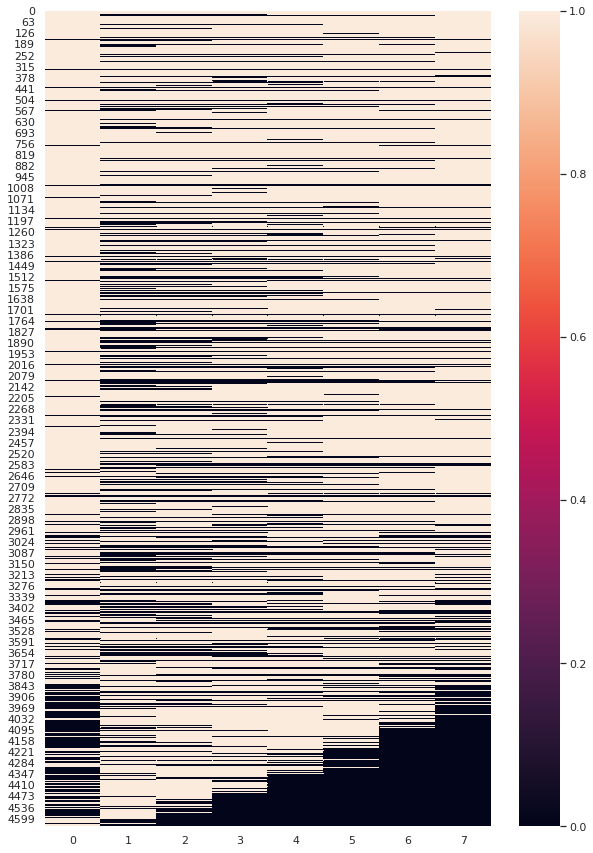

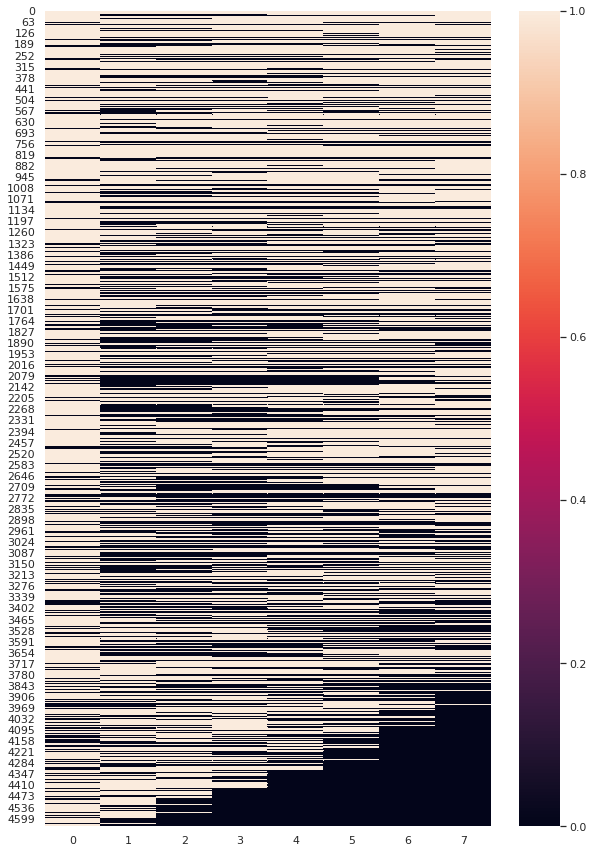

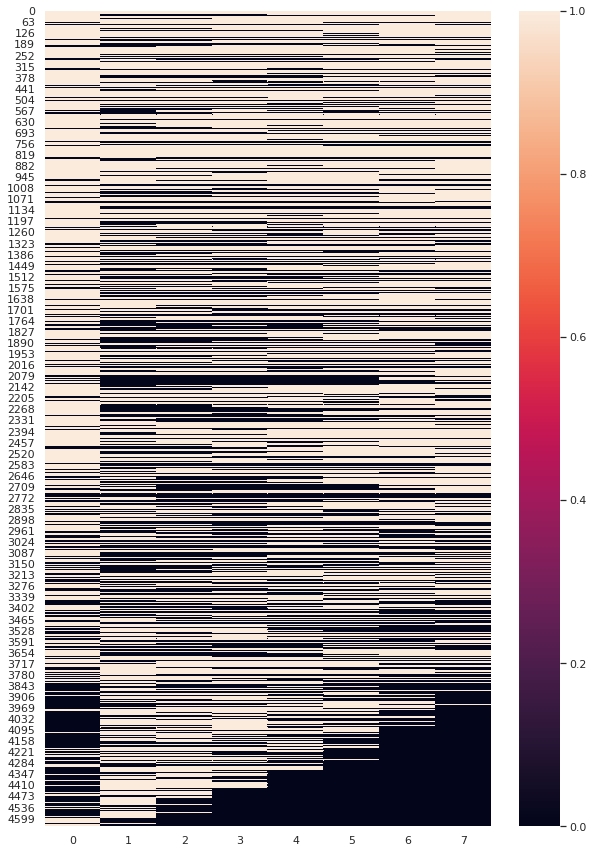

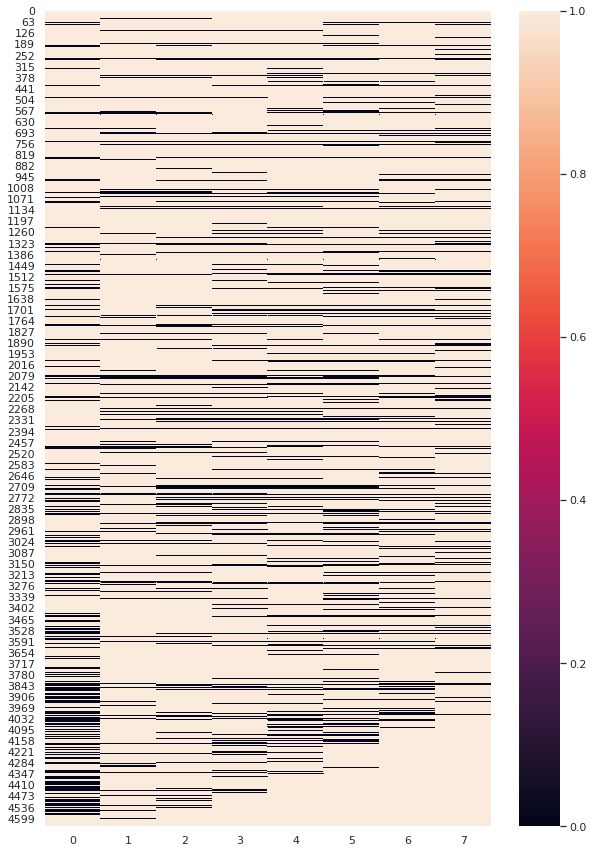

In [66]:
plt.figure()
sns.heatmap(binary_text)
plt.savefig("MetricFilingYear_Without3_Text_Heatmap.jpg")

plt.figure()
sns.heatmap(binary_metrics)
plt.savefig("MetricFilingYear_Without3_Metric_Heatmap.jpg")

plt.figure()
sns.heatmap(binary_both)
plt.savefig("MetricFilingYear_Without3_Both_Heatmap.jpg")

plt.figure()
sns.heatmap(binary_same)
plt.savefig("MetricFilingYear_Without3_BothEqual_Heatmap.jpg")

# Merge Data, Write to disk

In [12]:
num_pred = float(len(predictions))
num_text = float(len(text_dfs))

In [13]:
result = pd.merge(text_dfs, predictions, on=["cik", "filing_date"])

num_result = float(len(result))
num_text_lost = num_text - num_result
num_pred_lost = num_pred - num_result

ticker_mismatch = result["ticker_x"] != result["ticker_y"]
display("# and % of 10-K filings lost: ({:n},{:.0%})".format(num_text_lost, num_text_lost/ num_text))
display("# and % of stock events lost: ({:n},{:.0%})".format(num_pred_lost, num_pred_lost / num_pred))
display("# and % of ticker mismatches: ({:n},{:.0%})".format(ticker_mismatch.sum(), float(ticker_mismatch.sum()) / num_result))

'# and % of 10-K filings lost: (11316,31%)'

'# and % of stock events lost: (2000,7%)'

'# and % of ticker mismatches: (598,2%)'

In [14]:
result = pd.merge(text_dfs, predictions, on=["cik", "filing_year"])

num_result = float(len(result))
num_text_lost = num_text - num_result
num_pred_lost = num_pred - num_result

ticker_mismatch = result["ticker_x"] != result["ticker_y"]
filing_date_mismatch = result["filing_date_x"] != result["filing_date_y"]
ticker_and_filing_mismatch = ticker_mismatch & filing_date_mismatch
ticker_or_filing_mismatch = ticker_mismatch | filing_date_mismatch

display("# and % of 10-K filings lost: ({:n},{:.0%})".format(num_text_lost, num_text_lost/ num_text))
display("# and % of stock events lost: ({:n},{:.0%})".format(num_pred_lost, num_pred_lost / num_pred))
display("# and % of ticker mismatches: ({:n},{:.0%})".format(ticker_mismatch.sum(), float(ticker_mismatch.sum()) / num_result))
display("# and % of filing date mismatches: ({:n},{:.0%})".format(filing_date_mismatch.sum(), float(filing_date_mismatch.sum()) / num_result))
display("# and % of ticker and filing date mismatches: ({:n},{:.0%})".format(ticker_and_filing_mismatch.sum(), float(ticker_and_filing_mismatch.sum()) / num_result))
display("# and % of ticker or filing date mismatches: ({:n},{:.0%})".format(ticker_or_filing_mismatch.sum(), float(ticker_or_filing_mismatch.sum()) / num_result))

'# and % of 10-K filings lost: (11289,31%)'

'# and % of stock events lost: (1973,7%)'

'# and % of ticker mismatches: (599,2%)'

'# and % of filing date mismatches: (27,0%)'

'# and % of ticker and filing date mismatches: (1,0%)'

'# and % of ticker or filing date mismatches: (625,2%)'

In [16]:
result[filing_date_mismatch]

,cik,ticker_x,filing_date_x,item1a_risk,item7_mda,year_x,filing_year,perm_id,ticker_y,year_y,filing_date_y,company_name,is_dividend_payer,dps_change,is_dps_cut,z_environmental,d_environmental,sector
963,77597,SEH,2011-12-21,>ITEM 1A. RISK FACTORSIN EVALUATING THE COMPAN...,>Item 7 contains financial information prepare...,2011,2011,2569,SEH,2010,2011-01-13,SPARTECH CORP,0.0,NaN,NaN,NaN,NaN,Industrials
1089,109177,SPB,2011-12-14,>Item 1A. Risk Factors Risks Related to HGI We...,>Item 7. Management s Discussion and Analysis ...,2011,2011,3735,SPB,2010,2011-03-11,SPECTRUM BRANDS HOLDINGS INC,0.0,NaN,NaN,NaN,NaN,Industrials
1446,808326,EMKR,2011-01-10,>ITEM 1A. Risk Factors We have a history of in...,>ITEM 7. Management s Discussion and Analysis ...,2011,2011,1055,EMKR,2011,2011-12-29,EMCORE CORP,0.0,NaN,NaN,NaN,NaN,Tech
3735,718789,SHFL,2012-12-21,>ITEM 1A. RISK FACTORS RISKS RELATED TO OUR BU...,>ITEM 7. MANAGEMENT'S DISCUSSION AND ANALYSIS ...,2012,2012,40,SHFL,2011,2012-01-05,SHFL ENTERTAINMENT INC,0.0,NaN,NaN,NaN,NaN,Industrials
4929,1099941,MVC,2012-01-12,>Item 1A. RISK FACTORS Investing in MVC Capita...,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2012,2012,4564,MVC,2012,2012-12-27,MVC CAPITAL INC,1.0,0.086957,0.0,0.580647,-0.279010,Financials
6933,914712,MLNK,2013-10-15,>ITEM 1A. RISK FACTORS We operate in a rapidl...,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS...,2013,2013,619,MLNK,2012,2013-01-11,STEEL CONNECT INC,0.0,NaN,NaN,NaN,NaN,Tech
8118,1409493,CIM,2013-03-08,>Item 1A. Risk Factors If any of the following...,>Item 7. Management's Discussion and Analysis ...,2013,2013,3610,CIM,2012,2013-12-31,CHIMERA INVESTMENT CORP,1.0,0.000000,0.0,-0.597933,-0.279010,Financials
8193,1457543,CFN,2013-01-31,>ITEM 1A. RISK FACTORS We urge you to carefull...,>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2013,2013,3682,CFN,2013,2013-08-09,CAREFUSION CORP,0.0,NaN,NaN,0.346984,-0.011039,Health Care
8300,1504747,SWSH,2013-02-26,">ITEM 1A. RISK FACTORS. Our business, financia...",>ITEM 7. MANAGEMENT S DISCUSSION AND ANALYSIS ...,2013,2013,1417,SWSH,2012,2013-05-01,SWISHER HYGIENE INC,0.0,NaN,NaN,0.947447,NaN,Consumer
9102,790703,TECD,2014-02-05,>ITEM 1A. Risk Factors. The following are cert...,>ITEM 7.Management s Discussion and Analysis o...,2014,2014,157,TECD,2014,2014-04-09,TECH DATA CORP,0.0,NaN,NaN,-0.391493,-0.476001,Tech


In [11]:
result = pd.merge(text_dfs, predictions, left_on=["cik", "year"], right_on=["cik", "filing_year"])

num_result = float(len(result))
num_text_lost = num_text - num_result
num_pred_lost = num_pred - num_result

ticker_mismatch = result["ticker_x"] != result["ticker_y"]
filing_date_mismatch = result["filing_date_x"] != result["filing_date_y"]
ticker_and_filing_mismatch = ticker_mismatch & filing_date_mismatch
ticker_or_filing_mismatch = ticker_mismatch | filing_date_mismatch

display("# and % of 10-K filings lost: ({:n},{:.0%})".format(num_text_lost, num_text_lost/ num_text))
display("# and % of stock events lost: ({:n},{:.0%})".format(num_pred_lost, num_pred_lost / num_pred))
display("# and % of ticker mismatches: ({:n},{:.0%})".format(ticker_mismatch.sum(), float(ticker_mismatch.sum()) / num_result))
display("# and % of filing date mismatches: ({:n},{:.0%})".format(filing_date_mismatch.sum(), float(filing_date_mismatch.sum()) / num_result))
display("# and % of ticker and filing date mismatches: ({:n},{:.0%})".format(ticker_and_filing_mismatch.sum(), float(ticker_and_filing_mismatch.sum()) / num_result))
display("# and % of ticker or filing date mismatches: ({:n},{:.0%})".format(ticker_or_filing_mismatch.sum(), float(ticker_or_filing_mismatch.sum()) / num_result))

'# and % of 10-K filings lost: (11289,31%)'

'# and % of stock events lost: (1973,7%)'

'# and % of ticker mismatches: (599,2%)'

'# and % of filing date mismatches: (27,0%)'

'# and % of ticker and filing date mismatches: (1,0%)'

'# and % of ticker or filing date mismatches: (625,2%)'

In [12]:
result = pd.merge(text_dfs, predictions, left_on=["cik", "filing_year"], right_on=["cik", "year"])

num_result = float(len(result))
num_text_lost = num_text - num_result
num_pred_lost = num_pred - num_result

ticker_mismatch = result["ticker_x"] != result["ticker_y"]
filing_date_mismatch = result["filing_date_x"] != result["filing_date_y"]
ticker_and_filing_mismatch = ticker_mismatch & filing_date_mismatch
ticker_or_filing_mismatch = ticker_mismatch | filing_date_mismatch

display("# and % of 10-K filings lost: ({:n},{:.0%})".format(num_text_lost, num_text_lost/ num_text))
display("# and % of stock events lost: ({:n},{:.0%})".format(num_pred_lost, num_pred_lost / num_pred))
display("# and % of ticker mismatches: ({:n},{:.0%})".format(ticker_mismatch.sum(), float(ticker_mismatch.sum()) / num_result))
display("# and % of filing date mismatches: ({:n},{:.0%})".format(filing_date_mismatch.sum(), float(filing_date_mismatch.sum()) / num_result))
display("# and % of ticker and filing date mismatches: ({:n},{:.0%})".format(ticker_and_filing_mismatch.sum(), float(ticker_and_filing_mismatch.sum()) / num_result))
display("# and % of ticker or filing date mismatches: ({:n},{:.0%})".format(ticker_or_filing_mismatch.sum(), float(ticker_or_filing_mismatch.sum()) / num_result))

'# and % of 10-K filings lost: (10847,30%)'

'# and % of stock events lost: (1531,6%)'

'# and % of ticker mismatches: (550,2%)'

'# and % of filing date mismatches: (19766,78%)'

'# and % of ticker and filing date mismatches: (412,2%)'

'# and % of ticker or filing date mismatches: (19904,78%)'

In [13]:
""" Relevant statistics post merge """
result = pd.merge(text_dfs, predictions, on=["cik", "year"])
num_result = float(len(result))
num_text_lost = num_text - num_result
num_pred_lost = num_pred - num_result

ticker_mismatch = result["ticker_x"] != result["ticker_y"]
filing_date_mismatch = result["filing_date_x"] != result["filing_date_y"]
ticker_and_filing_mismatch = ticker_mismatch & filing_date_mismatch
ticker_or_filing_mismatch = ticker_mismatch | filing_date_mismatch

display("# and % of 10-K filings lost: ({:n},{:.0%})".format(num_text_lost, num_text_lost/ num_text))
display("# and % of stock events lost: ({:n},{:.0%})".format(num_pred_lost, num_pred_lost / num_pred))
display("# and % of ticker mismatches: ({:n},{:.0%})".format(ticker_mismatch.sum(), float(ticker_mismatch.sum()) / num_result))
display("# and % of filing date mismatches: ({:n},{:.0%})".format(filing_date_mismatch.sum(), float(filing_date_mismatch.sum()) / num_result))
display("# and % of ticker and filing date mismatches: ({:n},{:.0%})".format(ticker_and_filing_mismatch.sum(), float(ticker_and_filing_mismatch.sum()) / num_result))
display("# and % of ticker or filing date mismatches: ({:n},{:.0%})".format(ticker_or_filing_mismatch.sum(), float(ticker_or_filing_mismatch.sum()) / num_result))

'# and % of 10-K filings lost: (10847,30%)'

'# and % of stock events lost: (1531,6%)'

'# and % of ticker mismatches: (550,2%)'

'# and % of filing date mismatches: (19766,78%)'

'# and % of ticker and filing date mismatches: (412,2%)'

'# and % of ticker or filing date mismatches: (19904,78%)'

In [ ]:
# We can conduct analysis by filtering by either cik (by company), or by year
result.drop(columns=["ticker_x", "filing_date_x", "ticker_y", "filing_date_y", "cik"], inplace=True)
result.head(5)

In [ ]:
result.write_csv("processed_data.csv")